In [172]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 500

Video to Frame

In [115]:
video_path = '/Users/braydennoh/Downloads/DSC_0173.MOV'
output_dir = '/Users/braydennoh/Downloads/floc1'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

cap = cv2.VideoCapture(video_path)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_1080p = cv2.resize(frame, (1920, 1080))
    output_filename = os.path.join(output_dir, f'frame_{frame_count:04d}.png')
    cv2.imwrite(output_filename, frame_1080p)
    frame_count += 1

cap.release()
print(f'Extracted {frame_count} frames and saved to {output_dir}')

Extracted 1623 frames and saved to /Users/braydennoh/Downloads/floc1


Calculate FPS

In [116]:
video_path = '/Users/braydennoh/Downloads/DSC_0173.MOV'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

video_duration = total_frames / cap.get(cv2.CAP_PROP_FPS)

fps = total_frames / video_duration

print(f"The estimated frames per second (fps) of the video is: {fps}")

cap.release()

The estimated frames per second (fps) of the video is: 29.97002997002997


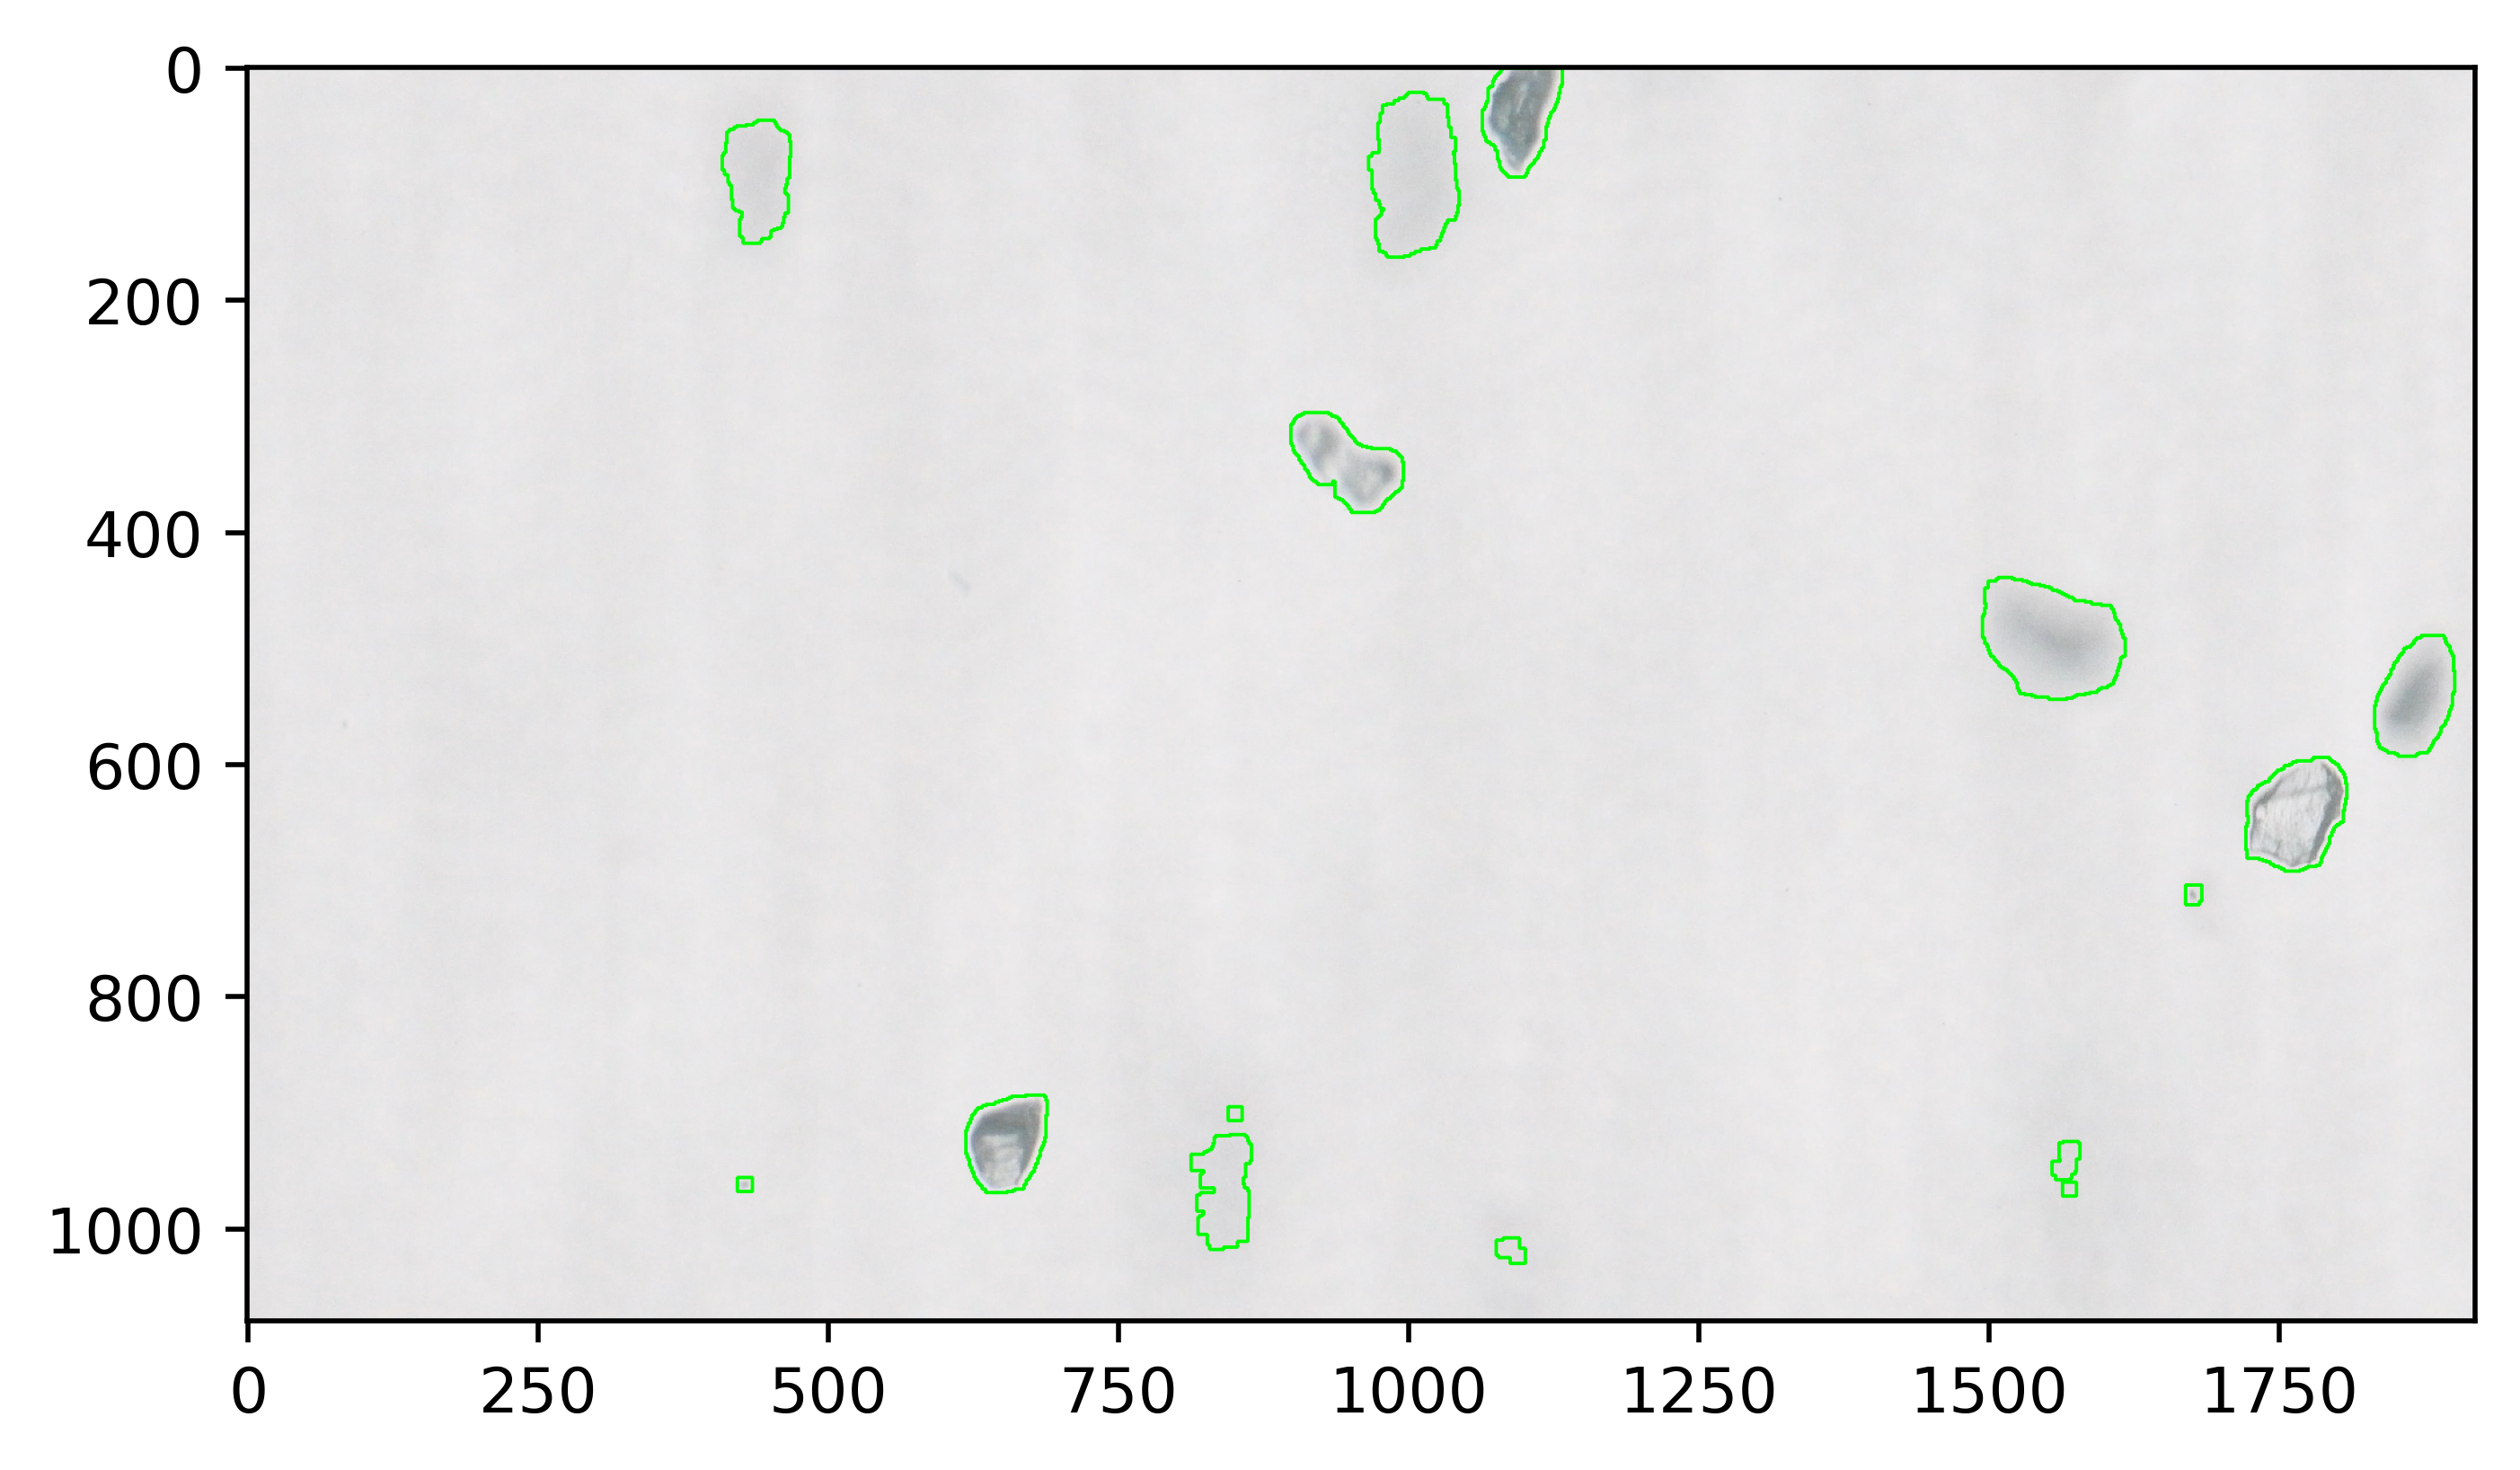

In [150]:
mpl.rcParams['figure.dpi'] = 500
image_path = '/Users/braydennoh/Downloads/floc1/frame_0952.png'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_float = gray.astype(np.float32) / 255.0
filtered_gray_float = gray_float 
filtered_gray = (filtered_gray_float * 255).astype(np.uint8)
equalized_gray = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(equalized_gray, (5, 5), 10)
ret, thresh = cv2.threshold(blurred, 5, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
dilation_kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(cleaned, dilation_kernel, iterations=5)
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

plt.imshow(dilated)
plt.imshow(contour_image)

In [165]:
avgimage = 0

os.chdir('/Users/braydennoh/Downloads/floc1')

def find_particles_centers_and_circularity(image, frame_num, avgimage):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_float = gray.astype(np.float32) / 255.0  
    filtered_gray_float = gray_float - avgimage 
    filtered_gray = (filtered_gray_float * 255).astype(np.uint8)  

    equalized_gray = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized_gray, (5, 5), 10)
    ret, thresh = cv2.threshold(blurred, 5, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    dilation_kernel = np.ones((3, 3), np.uint16)
    dilated = cv2.dilate(cleaned, dilation_kernel, iterations=5)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centers_circularity_sphericity_ids = []

    for cnt in contours:
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        masked_img = cv2.bitwise_and(blurred, blurred, mask=mask)
        laplacian = cv2.Laplacian(masked_img, cv2.CV_64F)
        laplacian_variance = laplacian.var()
        
        if laplacian_variance < 1 or laplacian_variance > 10:
            continue
            
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        circularity = 4 * np.pi * (area / (perimeter ** 2)) if perimeter > 0 else 0
        sphericity = area / (perimeter ** 2 / (4 * np.pi)) if perimeter > 0 else 0  
    
        major_axis_length = 0
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            major_axis_length = max(ellipse[1])  
        else:
            rect = cv2.minAreaRect(cnt)
            major_axis_length = max(rect[1])  

        avg_intensity = cv2.mean(gray, mask=mask)[0]

        centers_circularity_sphericity_ids.append(((cx, cy), area, circularity, sphericity, major_axis_length, laplacian_variance, avg_intensity))

    return contours, centers_circularity_sphericity_ids

def process_frame_pair(frame_num1, frame_num2, avgimage):
    pixel_to_micron = 0.81
    time_between_frames = 1/30
    dilation_increase_per_iteration = 2  
    dilation_iterations = 5
    
    image1 = cv2.imread(f'frame_{frame_num1:04}.png')
    image2 = cv2.imread(f'frame_{frame_num2:04}.png')

    _, centers_circularity_sphericity_ids1 = find_particles_centers_and_circularity(image1, frame_num1, avgimage)
    _, centers_circularity_sphericity_ids2 = find_particles_centers_and_circularity(image2, frame_num2, avgimage)
    
    matched_particles = set()
    local_diameters = []
    local_velocities = []
    laplacian_variances = []
    local_circularities = []
    local_sphericities = []
    average_intensities = []

    for data1 in centers_circularity_sphericity_ids1:
        center1, area1, circularity1, sphericity1, major_axis_length1, laplacian_variance1, avg_intensity1 = data1
        best_match = match_by_circularity((center1, area1, circularity1, sphericity1), centers_circularity_sphericity_ids2,300)
        
        if best_match:
            center2, area2, circularity2, sphericity2, major_axis_length2, laplacian_variance2, avg_intensity2 = best_match
            if (center2, area2, circularity2, sphericity2) not in matched_particles:
                matched_particles.add((center2, area2, circularity2, sphericity2))

            total_dilation_increase = dilation_increase_per_iteration * dilation_iterations
            adjusted_major_axis_length1 = max(major_axis_length1 - total_dilation_increase, 0)
            
            diameterinpixel = 2 * np.sqrt(area1 / np.pi)
            adjusteddiameterinpixel = diameterinpixel - total_dilation_increase
            diameter_microns = adjusteddiameterinpixel * pixel_to_micron
            
            local_diameters.append(diameter_microns)
            vertical_distance_pixels = abs(center1[1] - center2[1])
            vertical_distance_microns = vertical_distance_pixels * pixel_to_micron
            velocity = vertical_distance_microns / time_between_frames
            local_velocities.append(velocity)
            laplacian_variances.append(laplacian_variance1)
            local_circularities.append(circularity1)
            local_sphericities.append(sphericity1)
            average_intensities.append(avg_intensity1)
    
    return local_diameters, local_velocities, laplacian_variances, local_circularities, local_sphericities, average_intensities

def match_by_circularity(center_circularity1, centers_circularity2, search_radius):
    best_match = None
    min_combined_diff = float('inf')

    center1, area1, circularity1, sphericity1 = center_circularity1[:4]

    for center2, area2, circularity2, sphericity2, major_axis_length2, laplacian_variance2, avg_intensity2 in centers_circularity2:
        distance = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)
        
        if distance <= search_radius:
            area_diff_ratio = abs(area1 - area2) / area1
            if area_diff_ratio <= 0.1:
                circularity_diff = abs(circularity1 - circularity2)
                sphericity_diff = abs(sphericity1 - sphericity2)
                combined_diff = circularity_diff + sphericity_diff
                
                if combined_diff < min_combined_diff:
                    min_combined_diff = combined_diff
                    best_match = (center2, area2, circularity2, sphericity2, major_axis_length2, laplacian_variance2, avg_intensity2)

    return best_match

all_diameters = []
all_velocities = []
all_laplacian_variances = []
all_circularities = []
all_sphericities = []
all_average_intensities = []

for frame_num in range(900, 1100):
    diameters, velocities, laplacian_variances, circularities, sphericities, average_intensities = process_frame_pair(frame_num, frame_num + 1, avgimage)
    all_diameters.extend(diameters)
    all_velocities.extend(velocities)
    all_laplacian_variances.extend(laplacian_variances)
    all_circularities.extend(circularities)
    all_sphericities.extend(sphericities)
    all_average_intensities.extend(average_intensities)

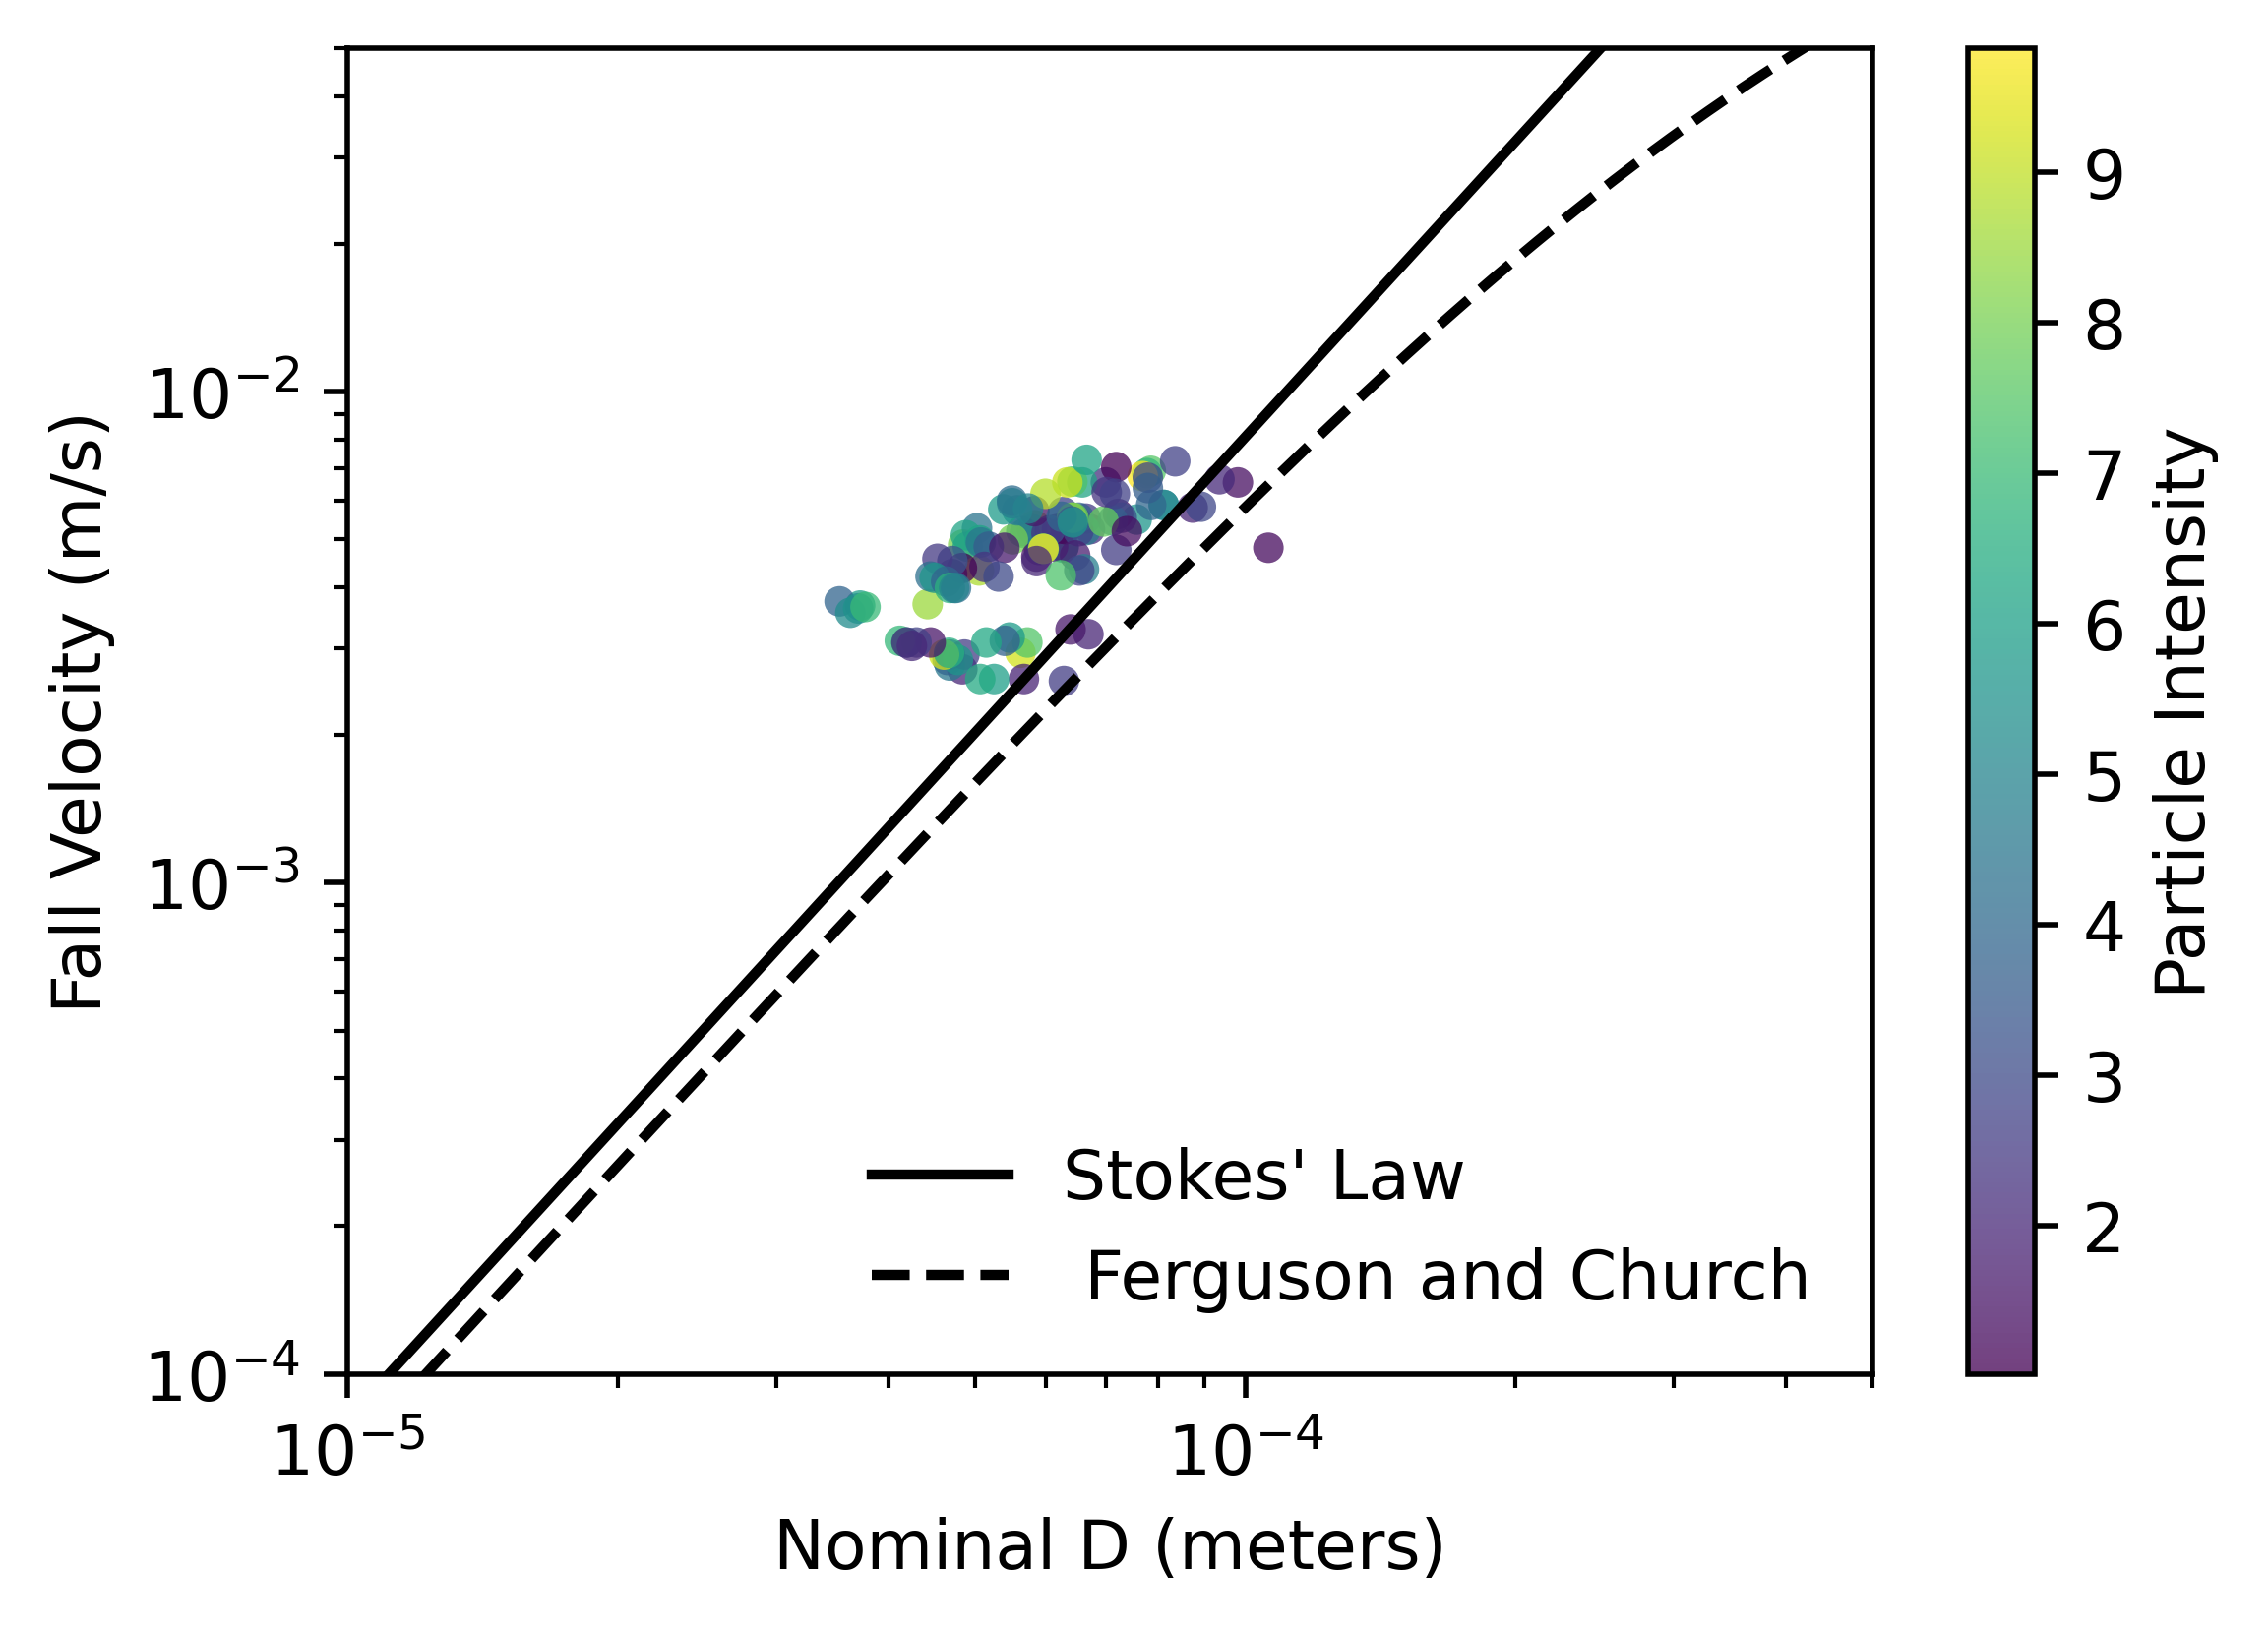

In [171]:
diametersmeters = [d / 1000000 for d in all_diameters]
velocitiesmeters = [v / 1000000 for v in all_velocities]

R = 1.65  
g = 9.81 
ν = 1.0e-6  
C1 = 20  
C2 = 1.1 

def stokes_law(D):
    return (R * g * D**2) / (C1 * ν)

def modified_stokes_law_rough(D):
    return (R * g * D**2) / (24 * ν + (0.75 * 1.2 * R * g * D**3)**0.5)

diameter_range_corrected = np.logspace(-5, -3, 10000)
fall_velocity = stokes_law(diameter_range_corrected)
fall_velocity_rough = modified_stokes_law_rough(diameter_range_corrected)
plt.figure(figsize=(5, 3.5))
plt.plot(diameter_range_corrected, fall_velocity, label="Stokes' Law",color='black')
plt.plot(diameter_range_corrected, fall_velocity_rough,  ls="--",label=" Ferguson and Church",color='black')
plt.scatter(diametersmeters, velocitiesmeters, c=all_laplacian_variances, cmap='viridis', s=20, alpha=0.75, edgecolor='none')
plt.colorbar(label='Particle Intensity')
plt.xlabel('Nominal D (meters)')
plt.ylabel('Fall Velocity (m/s)')
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.0001,0.05])
plt.xlim([0.00001,0.0005])
plt.legend(frameon=False)
plt.show()

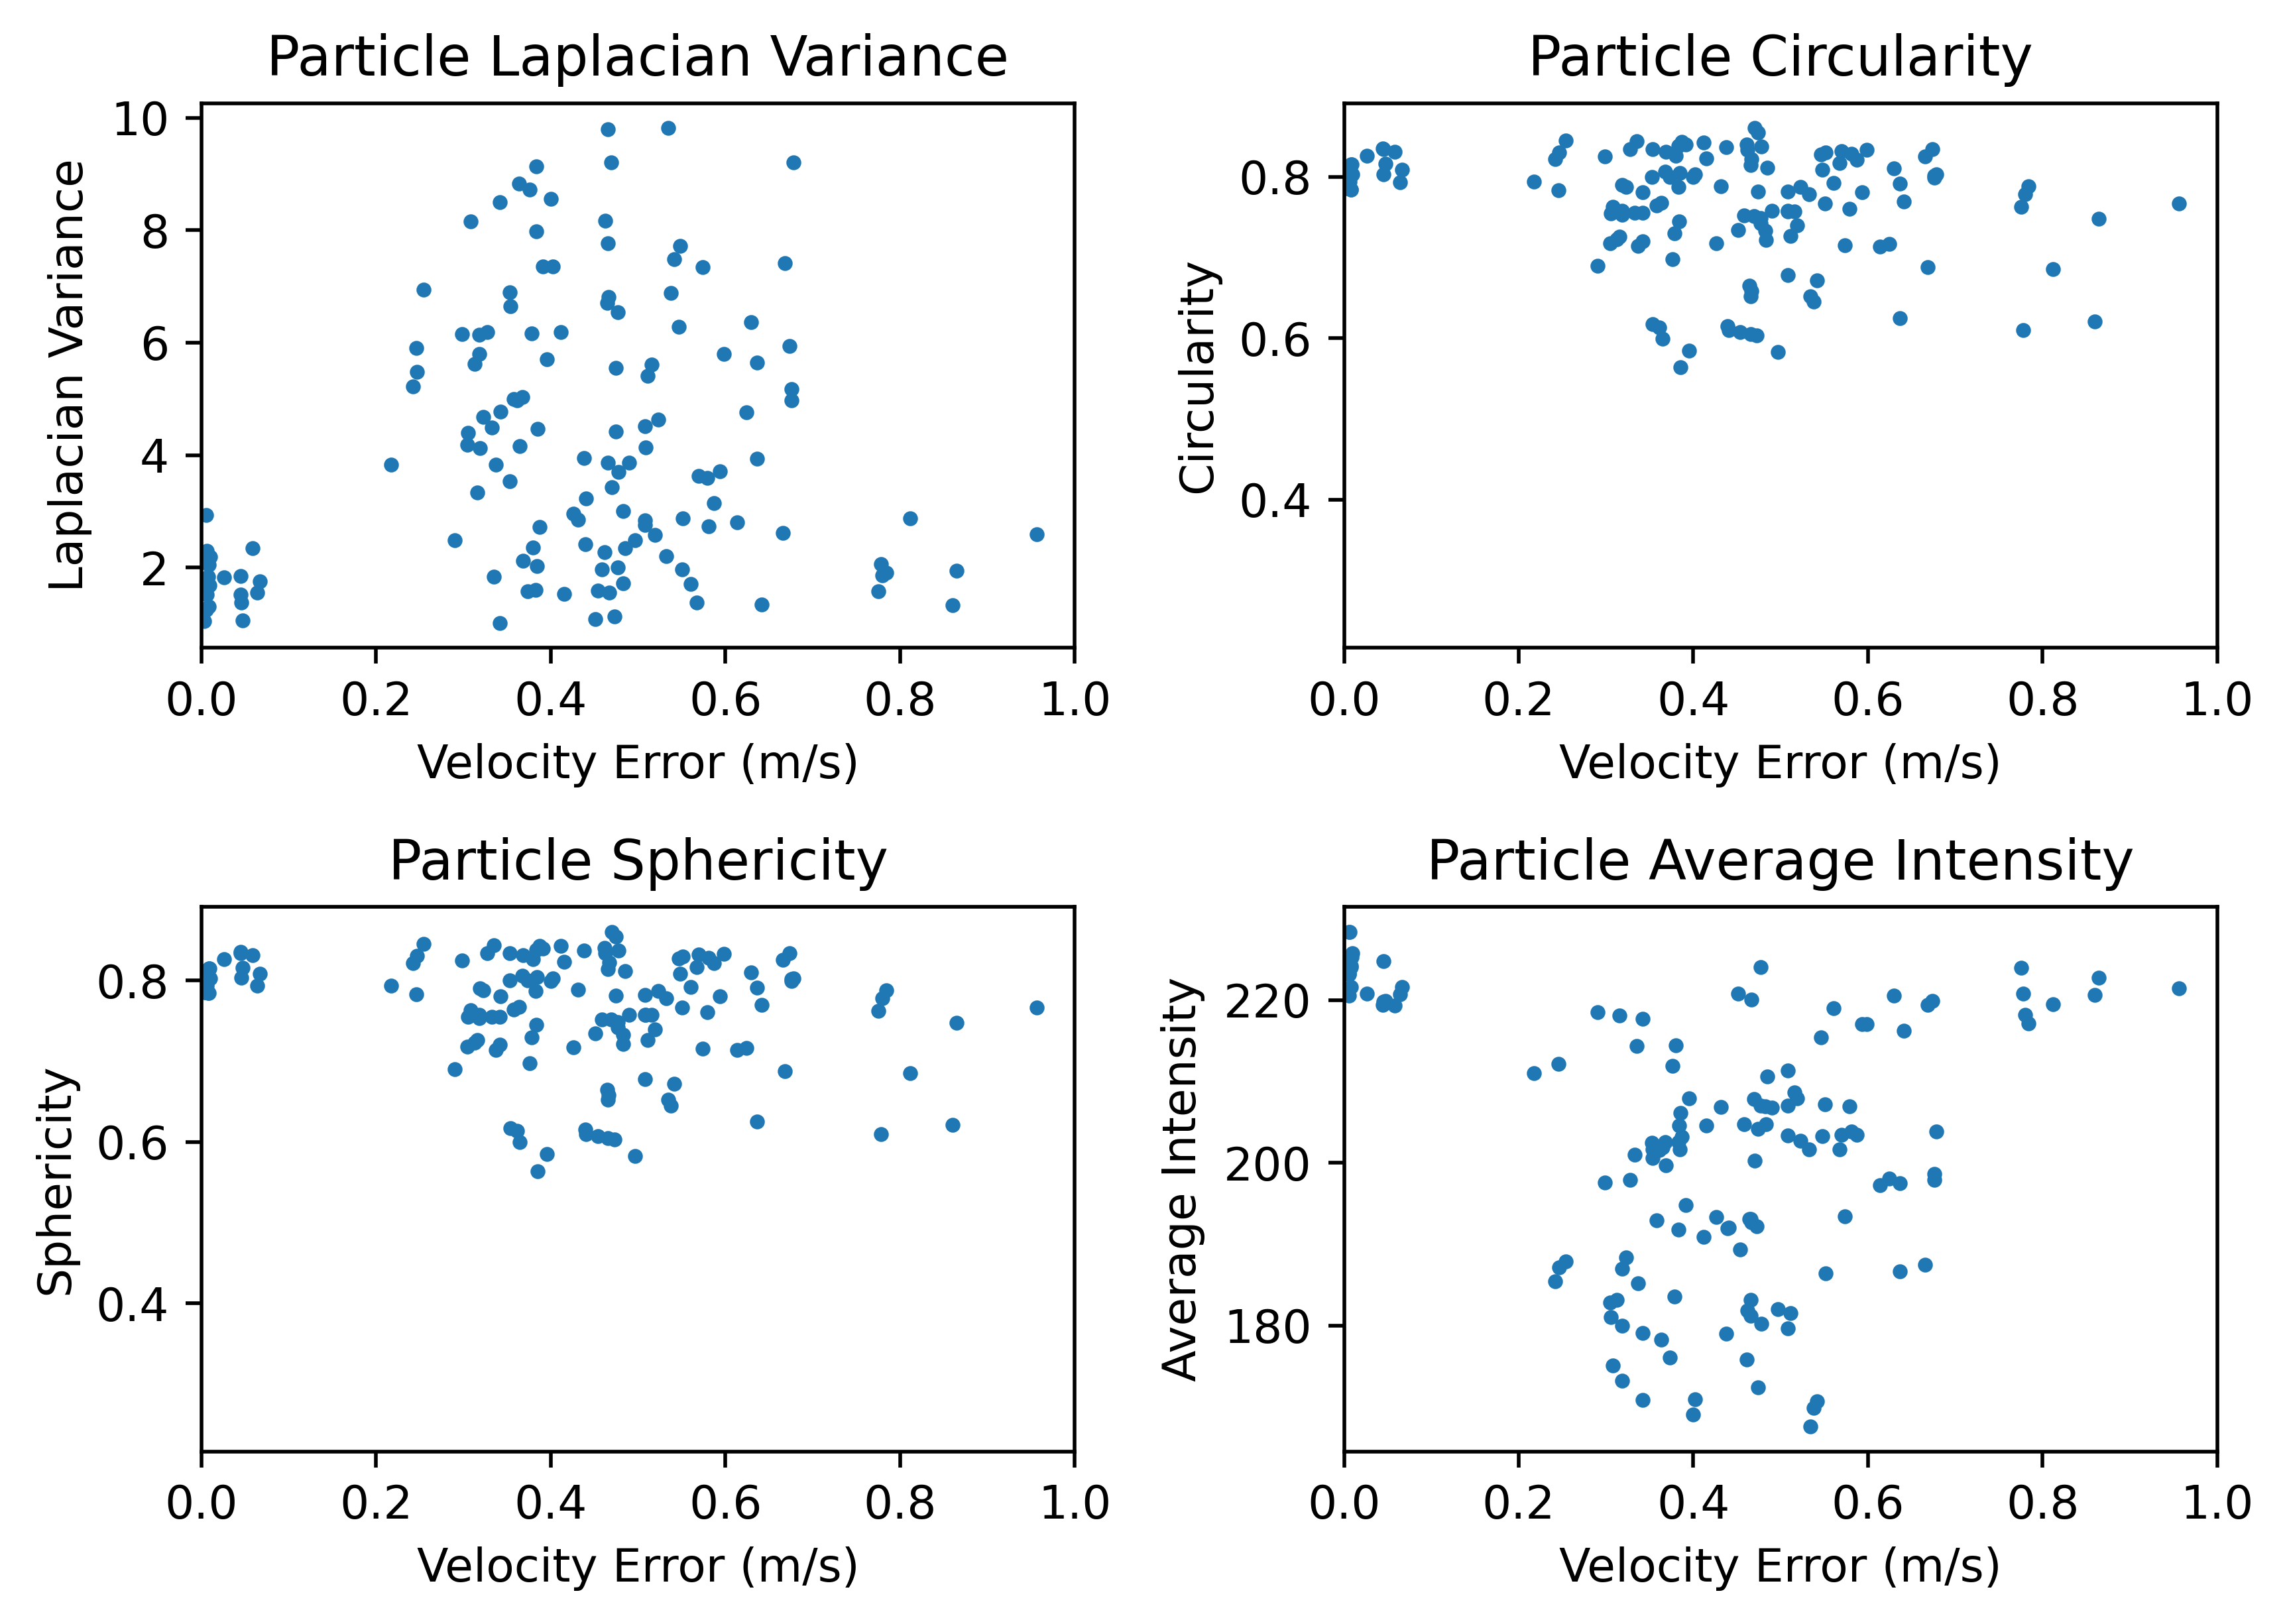

In [175]:
R = 1.65 
g = 9.81
ν = 1.0e-6 

diametersmeters = [d / 1000000 for d in all_diameters]
velocitiesmeters = [v / 1000000 for v in all_velocities]

def modified_stokes_law_rough(D):
    return (R * g * D**2) / (24 * ν + (0.75 * 1.2 * R * g * D**3)**0.5)

fall_velocity_rough = [modified_stokes_law_rough(d) for d in diametersmeters]
velocity_ratios = [theo / obs if obs != 0 else 0 for theo, obs in zip(fall_velocity_rough, velocitiesmeters)]

fig, axs = plt.subplots(2, 2, figsize=(7, 5))

axs[0, 0].scatter(velocity_ratios, all_laplacian_variances, s=5)
axs[0, 0].set_xlabel("Velocity Error (m/s)")
axs[0, 0].set_ylabel("Laplacian Variance")
axs[0, 0].set_title("Particle Laplacian Variance")
axs[0, 0].set_xlim(0, 1)  # Setting x-axis limit

axs[0, 1].scatter(velocity_ratios, all_circularities, s=5)
axs[0, 1].set_xlabel("Velocity Error (m/s)")
axs[0, 1].set_ylabel("Circularity")
axs[0, 1].set_title("Particle Circularity")
axs[0, 1].set_xlim(0, 1)  # Setting x-axis limit

axs[1, 0].scatter(velocity_ratios, all_sphericities, s=5)
axs[1, 0].set_xlabel("Velocity Error (m/s)")
axs[1, 0].set_ylabel("Sphericity")
axs[1, 0].set_title("Particle Sphericity")
axs[1, 0].set_xlim(0, 1)  # Setting x-axis limit

axs[1, 1].scatter(velocity_ratios, all_average_intensities, s=5)
axs[1, 1].set_xlabel("Velocity Error (m/s)")
axs[1, 1].set_ylabel("Average Intensity")
axs[1, 1].set_title("Particle Average Intensity")
axs[1, 1].set_xlim(0, 1) 

plt.tight_layout()
plt.show()

Mean Squared Error: 5.313281116834852e-07


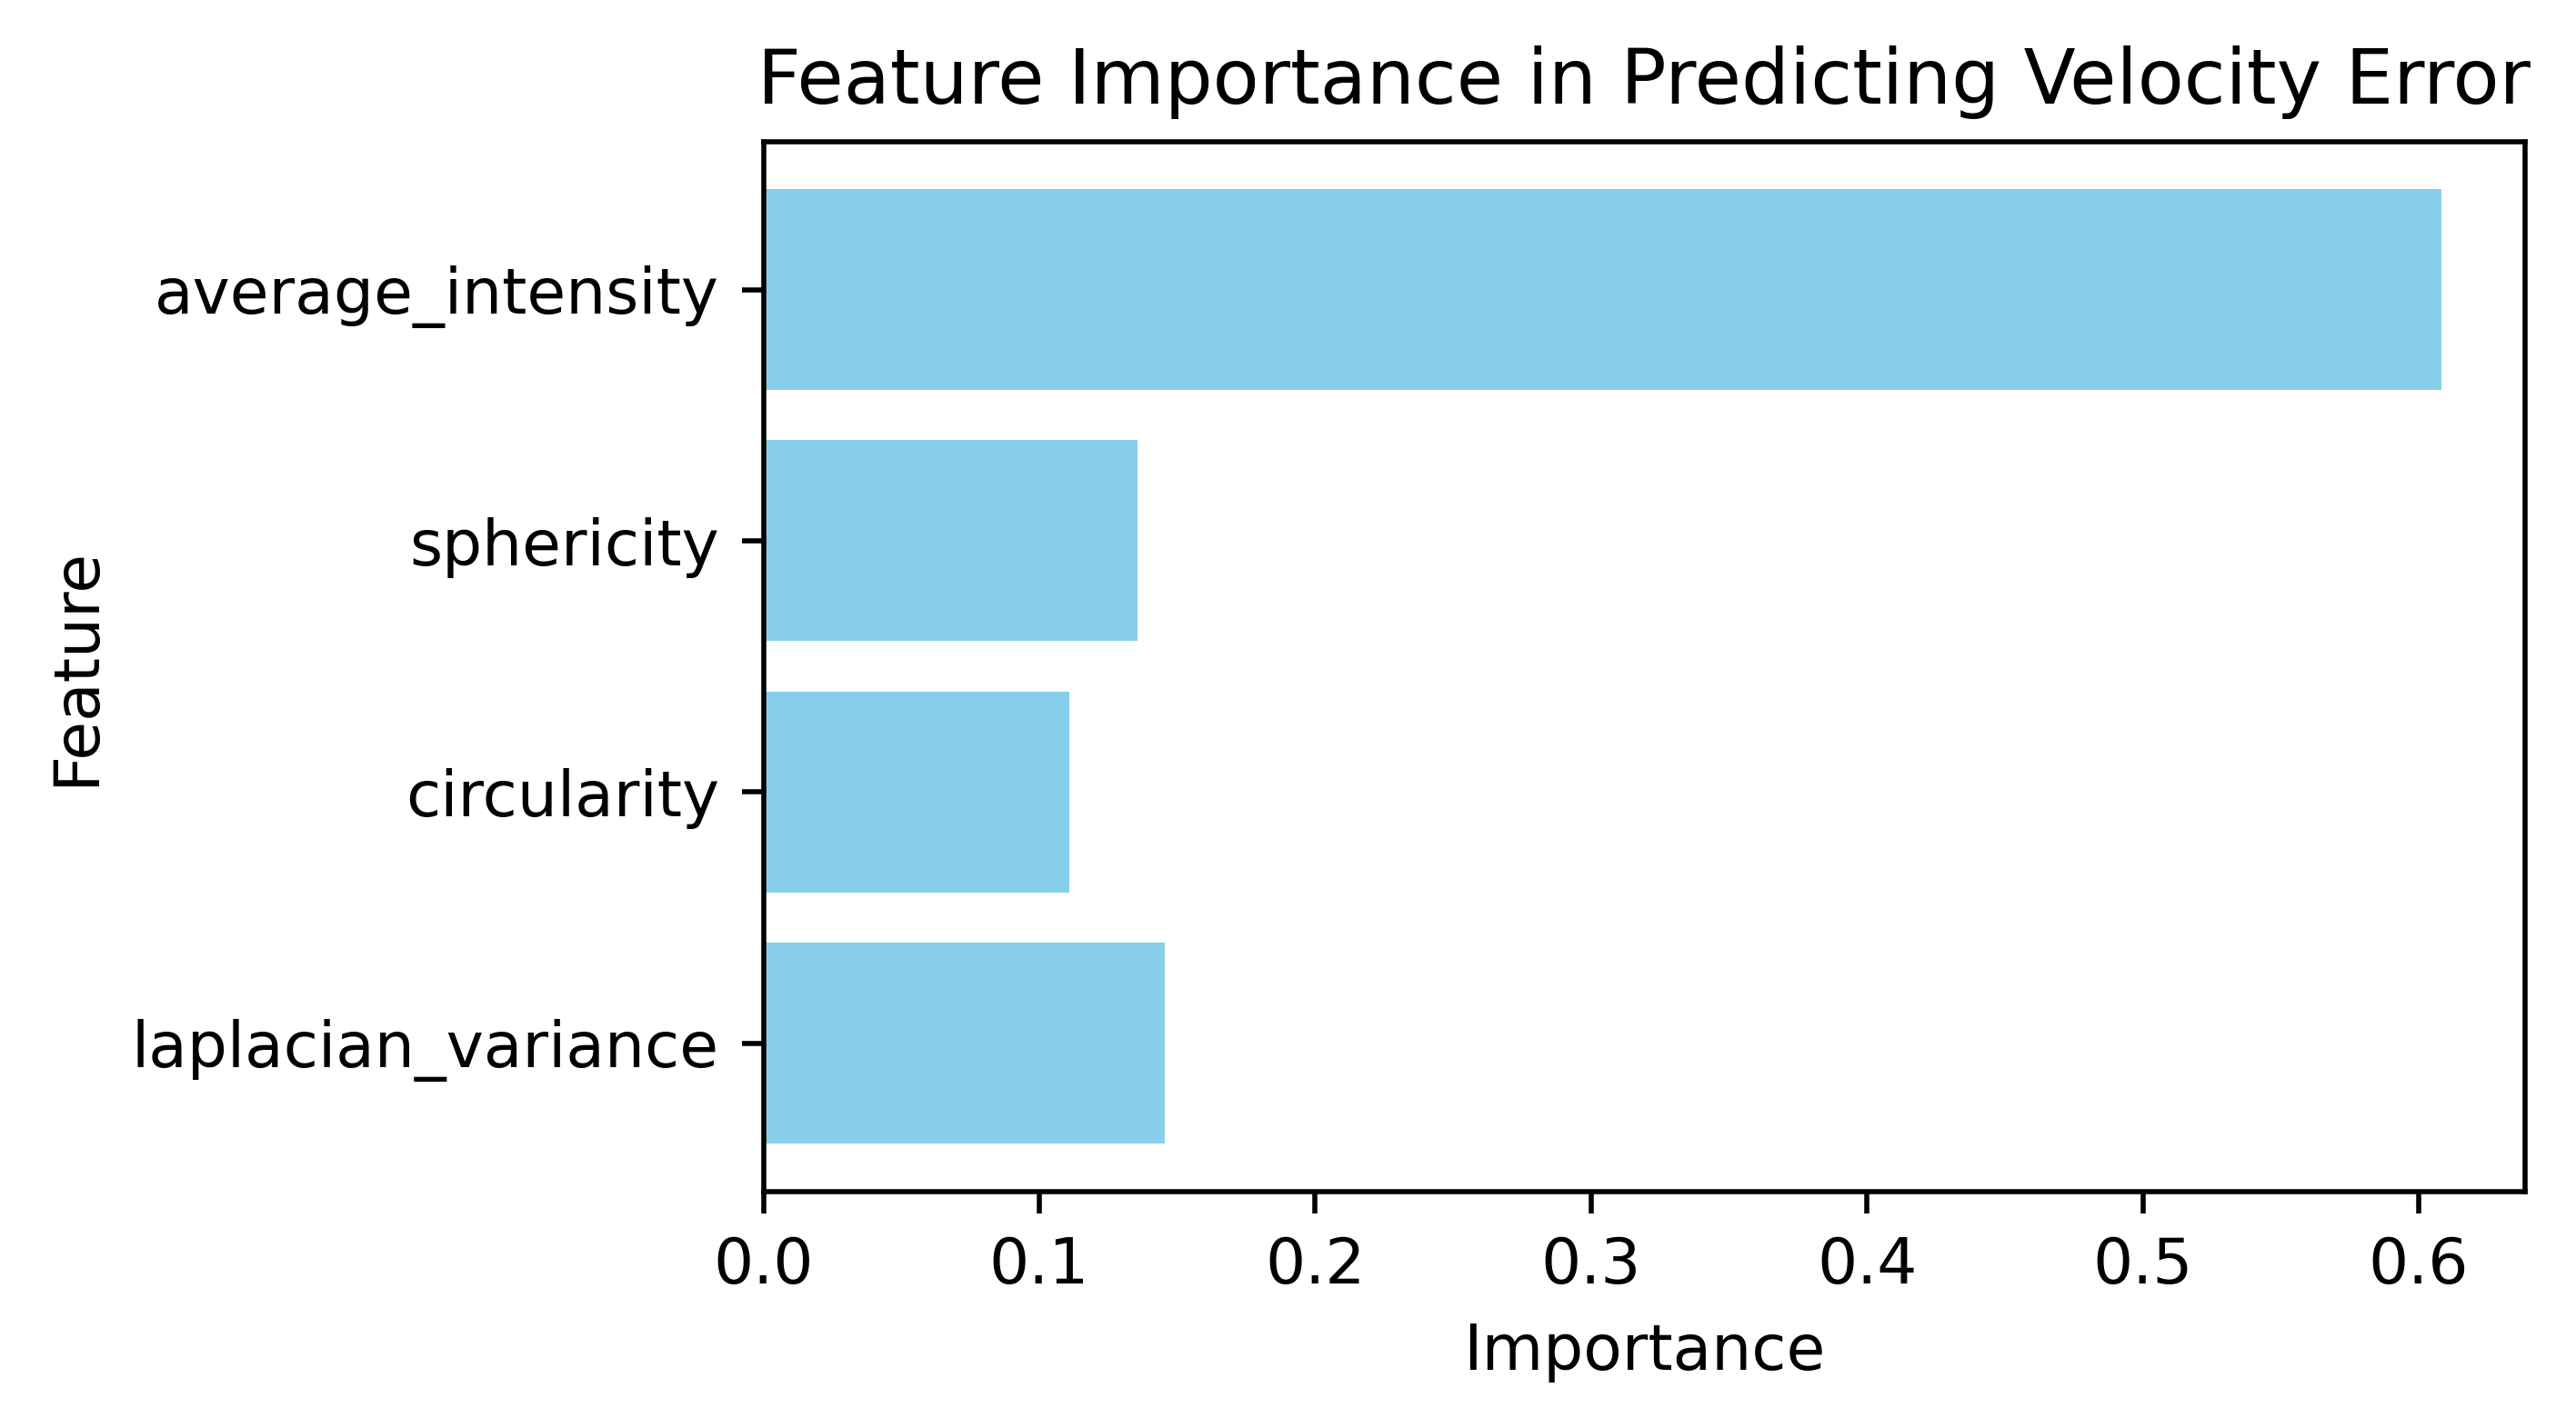

In [168]:
data = {
    'diameter': all_diameters,
    'velocity': all_velocities,
    'laplacian_variance': all_laplacian_variances,
    'circularity': all_circularities,
    'sphericity': all_sphericities,
    'average_intensity': all_average_intensities
}

df = pd.DataFrame(data)

df['diameter_m'] = df['diameter'] / 1000000
df['velocity_m'] = df['velocity'] / 1000000

df['theoretical_velocity'] = df['diameter_m'].apply(modified_stokes_law_rough)

df['velocity_error'] = df['velocity_m'] - df['theoretical_velocity']

features = df[['laplacian_variance', 'circularity', 'sphericity', 'average_intensity']]
target = df['velocity_error']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

feature_importances = rf.feature_importances_

feature_names = features.columns
plt.figure(figsize=(5, 3))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Velocity Error')
plt.show()

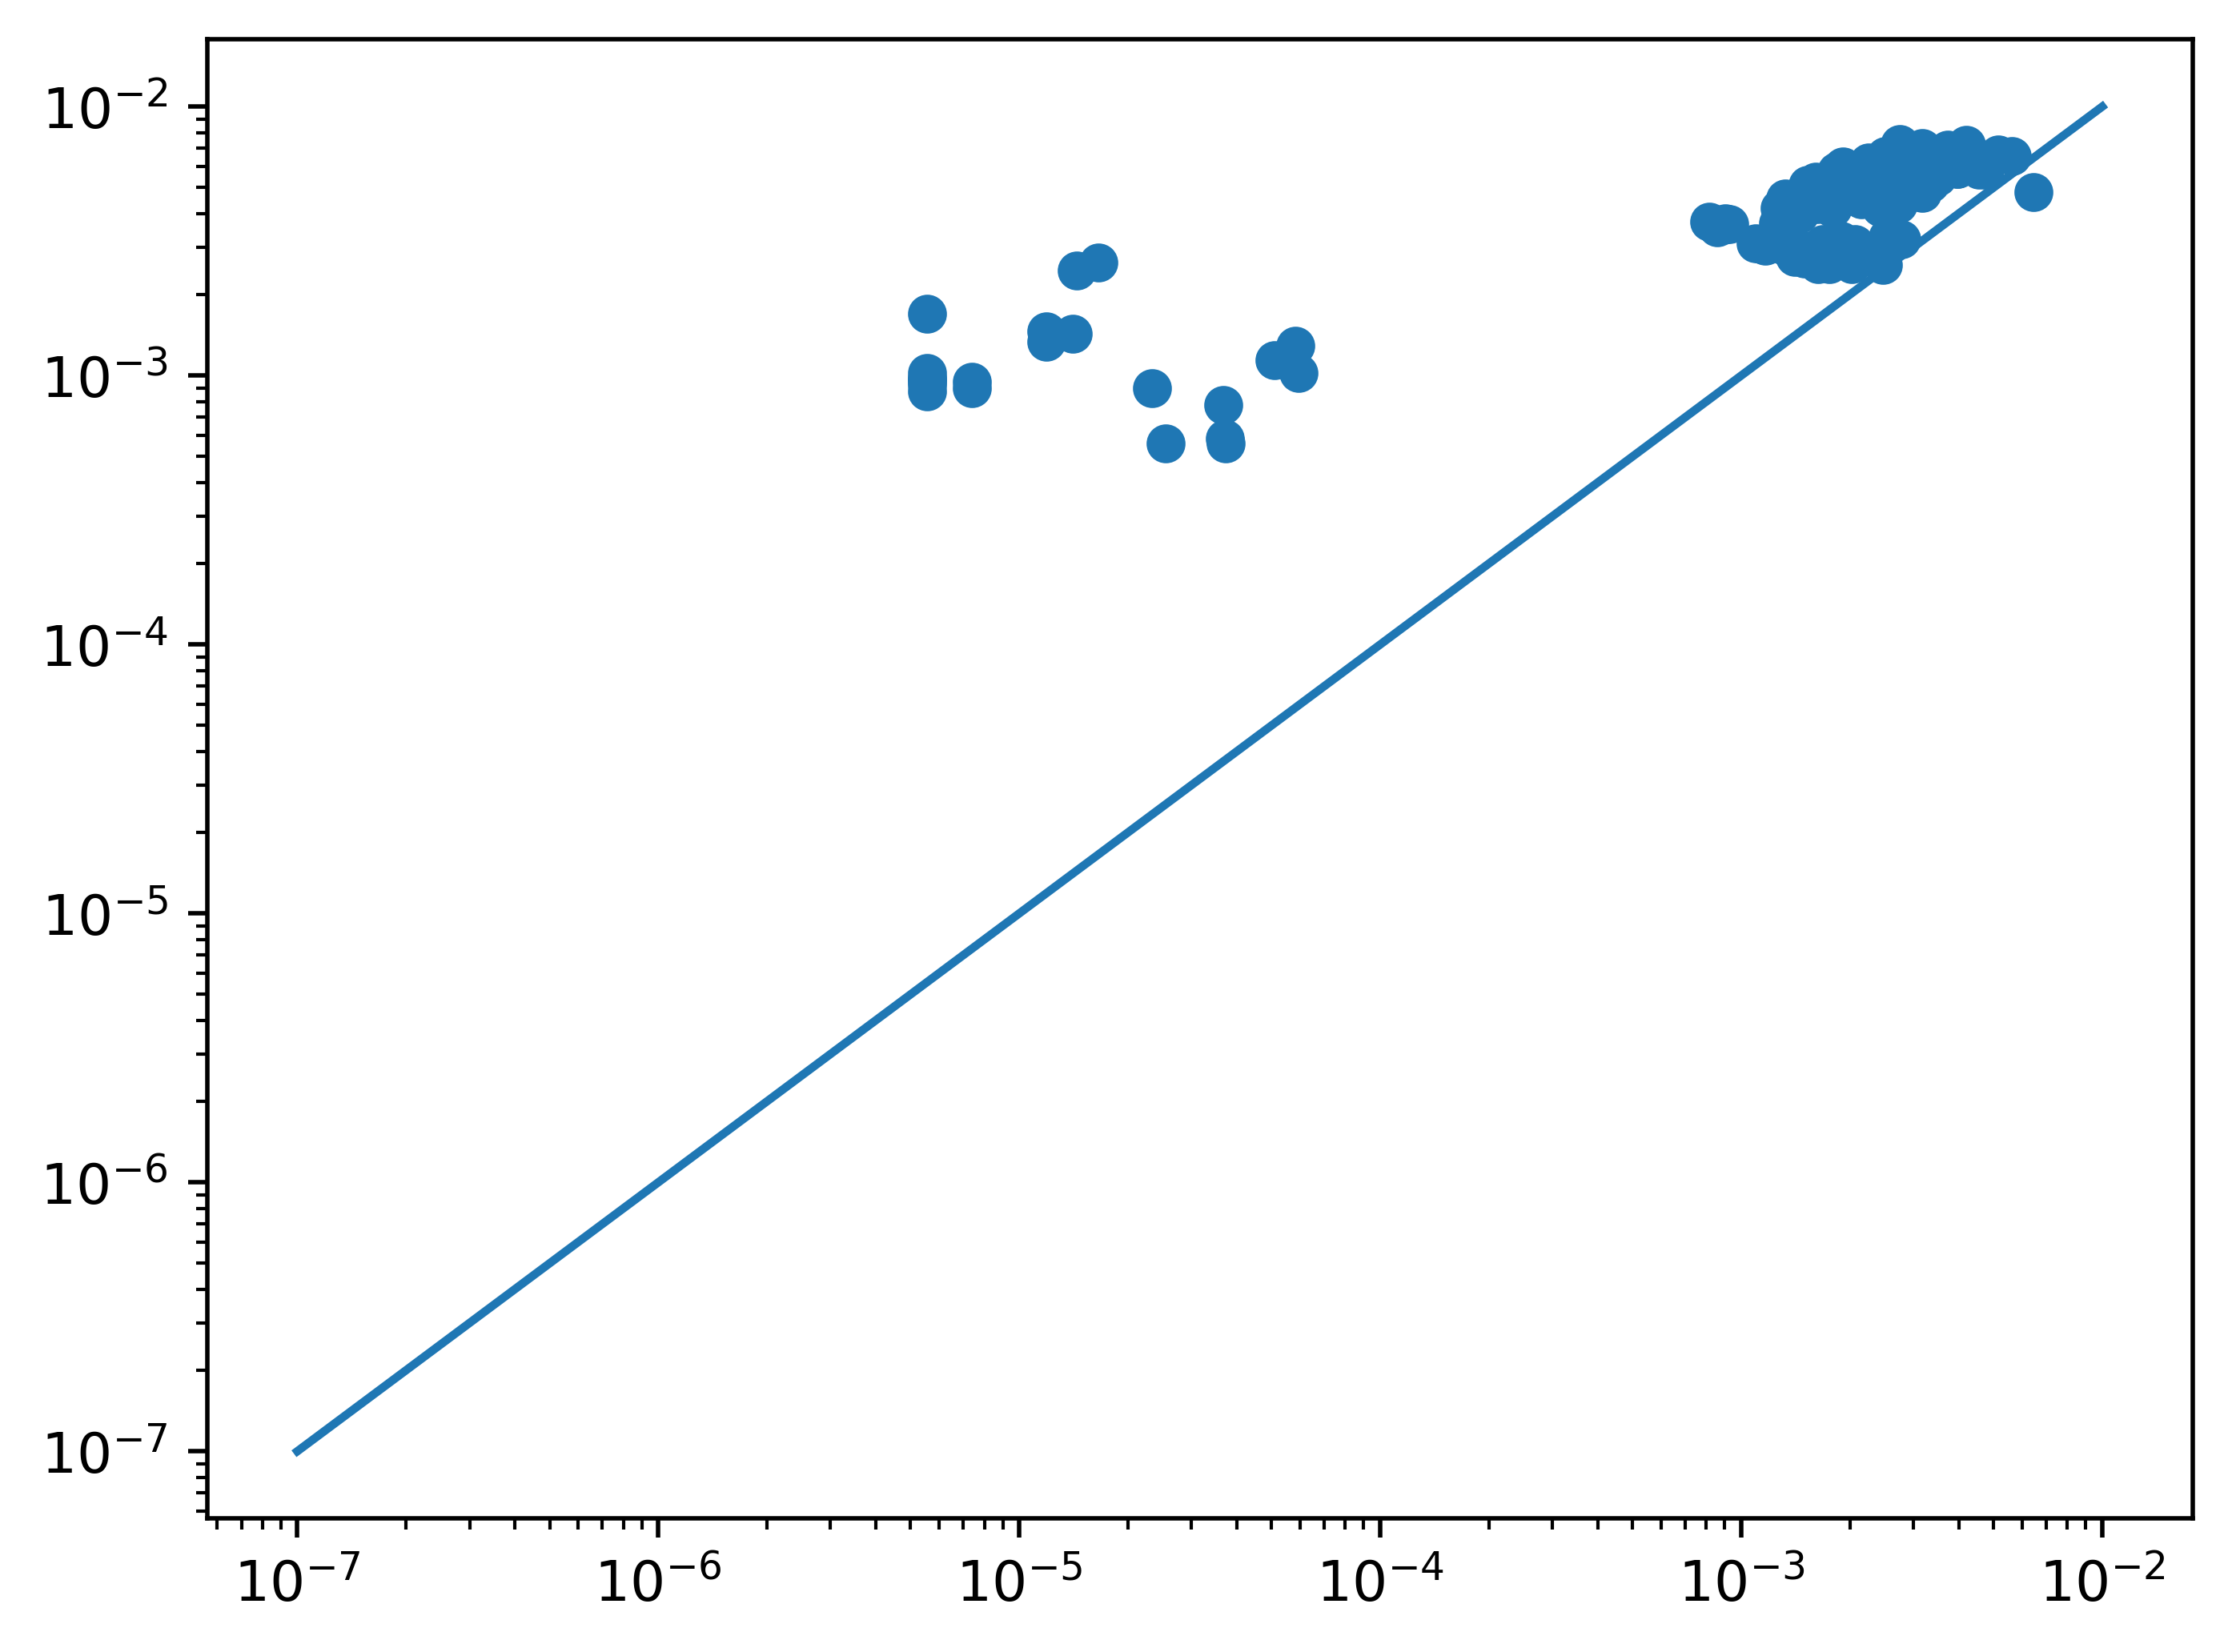

In [169]:
diametersmeters = [d / 1000000 for d in all_diameters]
velocitiesmeters = [v / 1000000 for v in all_velocities]

def modified_stokes_law_rough(D):
    return (R * g * D**2) / (24 * ν + (0.75 * 1.2 * R * g * D**3)**0.5)

fall_velocity_rough = [modified_stokes_law_rough(d) for d in diametersmeters]
plt.scatter(fall_velocity_rough,velocitiesmeters)
plt.plot([1e-7,1e-2],[1e-7,1e-2])
plt.xscale('log')
plt.yscale('log')